In [73]:
import pandas as pd
import multiprocessing as mp 
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import requests
import time
import json
import plotly.graph_objects as go
from IPython.display import clear_output

In [74]:
clean_22 = pd.read_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_22.pkl')
clean_23 = pd.read_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_23.pkl')
clean_22.head()

timestamp,2022-02-01 00:00:00,2022-02-01 01:00:00,2022-02-01 02:00:00,2022-02-01 03:00:00,2022-02-01 04:00:00,2022-02-01 05:00:00,2022-02-01 06:00:00,2022-02-01 07:00:00,2022-02-01 08:00:00,2022-02-01 09:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
station_complex_id,,,,,,,,,,,,,,,,,,,,,
1,17.0,5.0,6.0,12.0,44.0,143.0,405.0,735.0,950.0,512.0,...,426.0,402.0,304.0,338.0,322.0,350.0,309.0,293.0,168.0,75.0
10,100.0,24.0,7.0,8.0,8.0,14.0,43.0,98.0,175.0,182.0,...,3.0,4.0,4.0,4.0,3.0,4.0,5.0,8.0,5.0,2.0
100,10.0,3.0,0.0,3.0,5.0,17.0,46.0,68.0,106.0,66.0,...,68.0,69.0,69.0,55.0,58.0,61.0,67.0,52.0,56.0,25.0
101,26.0,10.0,9.0,3.0,20.0,49.0,124.0,245.0,394.0,247.0,...,286.0,316.0,332.0,269.0,239.0,246.0,239.0,209.0,179.0,104.0
118,21.0,11.0,9.0,3.0,1.0,9.0,14.0,61.0,75.0,54.0,...,249.0,279.0,245.0,245.0,287.0,273.0,278.0,281.0,245.0,115.0


In [3]:
def analyze_multiple_windows(df, station_id, windows=[24, 24*7, 24*30], figsize=(15, 12)):
    """
    Create subplots with different moving average windows.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with timestamp columns and station ridership index
    station_id : int or str
        Station ID to analyze (must be in the index)
    windows : list
        List of window sizes in hours
    figsize : tuple
        Figure size for the entire plot
    """
    # Get the data for the specific station
    station_data = pd.DataFrame(df.loc[station_id]).reset_index()
    station_data.columns = ['timestamp', 'ridership']
    station_data['timestamp'] = pd.to_datetime(station_data['timestamp'])
    
    fig, axes = plt.subplots(len(windows), 1, figsize=figsize)
    fig.suptitle(f'Multiple Time Window Analysis - Station {station_id}', 
                 fontsize=16, 
                 y=1.02)
    
    for ax, window in zip(axes, windows):
        # Calculate moving average for current window
        ma = station_data['ridership'].rolling(
            window=window, 
            center=True
        ).mean()
        
        # Plot on current subplot
        ax.plot(station_data['timestamp'], 
                station_data['ridership'], 
                alpha=0.4, 
                color='#2563eb',
                label='Raw Data')
        ax.plot(station_data['timestamp'], 
                ma, 
                color='#dc2626',
                linewidth=2,
                label=f'{window//24}-Day MA')
        
        ax.set_xlabel('Date')
        ax.set_ylabel('Ridership')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\one1c\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

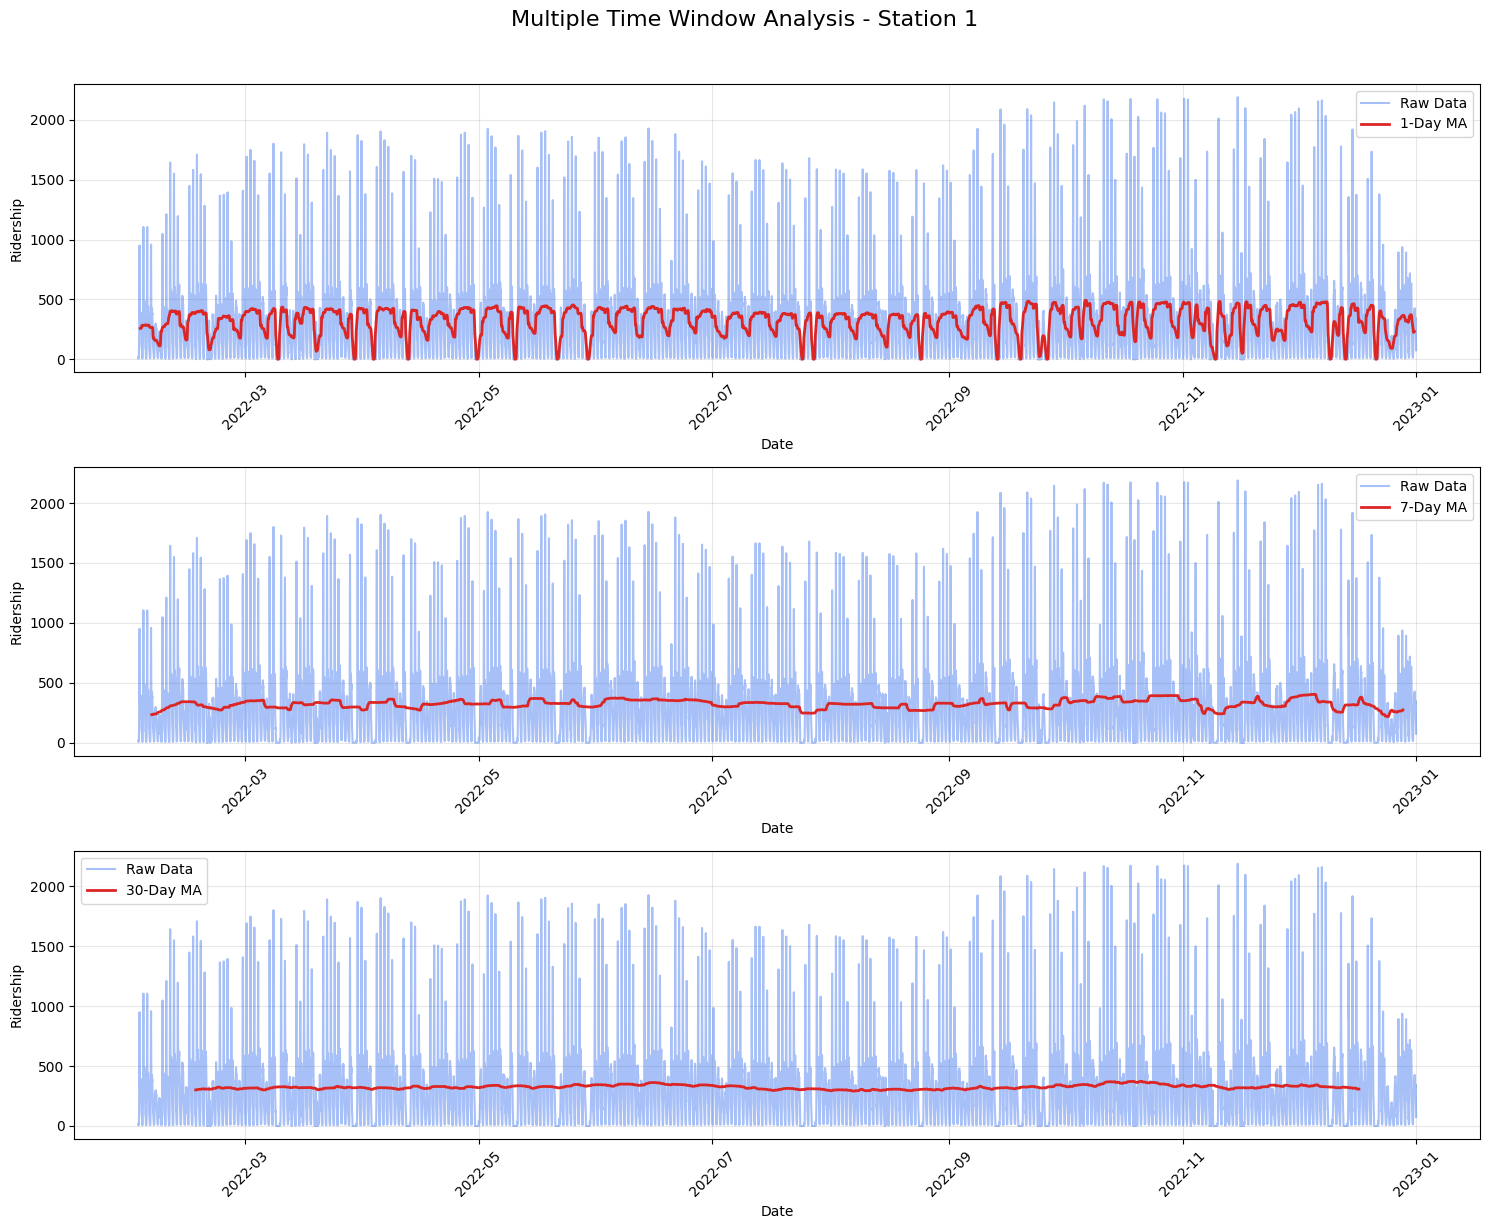

In [4]:
analyze_multiple_windows(clean_22, '1')

In [18]:
def create_interactive_timeseries(df_2022, df_2023=None):
    """
    Create an interactive time series visualization with dropdowns for station, window size, and year selection.
    
    Parameters:
    -----------
    df_2022 : pandas DataFrame
        DataFrame containing 2022 ridership data
    df_2023 : pandas DataFrame, optional
        DataFrame containing 2023 ridership data
    """
    
    # Create window size mapping
    window_labels = {
        24: 'Daily',
        168: 'Weekly',     # 24*7
        720: 'Monthly',    # 24*30
        2160: 'Quarterly'  # 24*90
    }
    
    # Create widgets
    station_dropdown = widgets.Dropdown(
        options=sorted(df_2022.index.unique().astype(str)),
        description='Station ID:',
        style={'description_width': 'initial'}
    )
    
    window_dropdown = widgets.Dropdown(
        options=[(label, hours) for hours, label in window_labels.items()],
        value=168,  # Default to weekly
        description='Window:',
        style={'description_width': 'initial'}
    )
    
    year_dropdown = widgets.Dropdown(
        options=['2022'] + (['2023', 'Both'] if df_2023 is not None else []),
        value='2022',
        description='Year:',
        style={'description_width': 'initial'}
    )
    
    def plot_timeseries(station, window_size, year):
        """Helper function to update the plot based on widget selections"""
        
        # Create figure
        fig = go.Figure()
        
        if year in ['2022', 'Both']:
            # Get 2022 data for selected station
            data_22 = pd.DataFrame(df_2022.loc[station]).reset_index()
            data_22.columns = ['timestamp', 'ridership']
            data_22['timestamp'] = pd.to_datetime(data_22['timestamp'])
            
            # Calculate moving average
            data_22['moving_avg'] = data_22['ridership'].rolling(
                window=window_size,
                center=True,
                min_periods=1
            ).mean()
            
            # Add 2022 traces
            fig.add_trace(
                go.Scatter(
                    x=data_22['timestamp'],
                    y=data_22['ridership'],
                    name='2022 Raw',
                    opacity=0.4,
                    line=dict(color='#2563eb')
                )
            )
            
            fig.add_trace(
                go.Scatter(
                    x=data_22['timestamp'],
                    y=data_22['moving_avg'],
                    name=f'2022 {window_labels[window_size]} MA',
                    line=dict(color='#2563eb', width=2)
                )
            )
        
        if year in ['2023', 'Both'] and df_2023 is not None:
            # Get 2023 data for selected station
            data_23 = pd.DataFrame(df_2023.loc[station]).reset_index()
            data_23.columns = ['timestamp', 'ridership']
            data_23['timestamp'] = pd.to_datetime(data_23['timestamp'])
            
            # Calculate moving average
            data_23['moving_avg'] = data_23['ridership'].rolling(
                window=window_size,
                center=True,
                min_periods=1
            ).mean()
            
            # Add 2023 traces
            fig.add_trace(
                go.Scatter(
                    x=data_23['timestamp'],
                    y=data_23['ridership'],
                    name='2023 Raw',
                    opacity=0.4,
                    line=dict(color='#dc2626')
                )
            )
            
            fig.add_trace(
                go.Scatter(
                    x=data_23['timestamp'],
                    y=data_23['moving_avg'],
                    name=f'2023 {window_labels[window_size]} MA',
                    line=dict(color='#dc2626', width=2)
                )
            )
        
        # Update layout
        fig.update_layout(
            title=f'Ridership Trends for Station {station}',
            xaxis_title='Date',
            yaxis_title='Ridership',
            template='plotly_white',
            height=600,
            showlegend=True,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=50, r=50, t=50, b=50)
        )
        
        # Add range slider
        fig.update_xaxes(rangeslider_visible=True)
        
        # Clear previous output and show new plot
        clear_output(wait=True)
        fig.show()
    
    # Create interactive widgets
    widgets.interact(
        plot_timeseries,
        station=station_dropdown,
        window_size=window_dropdown,
        year=year_dropdown
    )


In [19]:
create_interactive_timeseries(clean_22, clean_23)

interactive(children=(Dropdown(description='Station ID:', options=('1', '10', '100', '101', '118', '119', '120…

In [70]:
station_df = pd.read_csv(r'D:\capstone_F24\data\Cleaned_data\station_data.csv')
station_df.head()

C:\Users\one1c\AppData\Local\Temp\ipykernel_11712\3692923470.py:1: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



,station_complex_id,station_complex,borough,latitude,longitude,Georeference,nearby_attractions
0,59,9 Av (D),Brooklyn,40.646294,-73.99432,POINT (-73.99432 40.646294),"Borough Park Manor Condominium, Boro Park Cour..."
1,404,28 St (6),Manhattan,40.743070,-73.98426,POINT (-73.98426 40.74307),"The Churchill, NYC Wheelchair Transportation, ..."
2,272,"36 St (M,R)",Queens,40.752040,-73.92878,POINT (-73.92878 40.75204),"Materials for the Arts, Carolina Power Wellnes..."
3,420,"219 St (2,5)",Bronx,40.883896,-73.86263,POINT (-73.86263 40.883896),"Bibilis Wellness Center, Agnes Haywood Playground"
4,218,"167 St (B,D)",Bronx,40.833770,-73.91844,POINT (-73.91844 40.83377),"Askari Tours, Bronx Museum of the Arts, Mullal..."


In [112]:
station_dict = station_df.to_dict(orient='index')

In [131]:
def create_interactive_timeseries(df_2022, df_2023=None, station_info=None):
    """
    Create an interactive time series visualization with station details.
    
    Parameters:
    -----------
    df_2022 : pandas DataFrame
        DataFrame containing 2022 ridership data
    df_2023 : pandas DataFrame, optional
        DataFrame containing 2023 ridership data
    station_info : dict, optional
        Dictionary containing station information with structure:
        {
            id: {
                'station_complex_id': 'id',
                'station_complex': 'Station Name',
                'borough': 'Borough Name',
                'nearby_attractions': 'POI1, POI2, ...',
                ... any other details ...
            }
        }
    """
    
    # Create window size mapping
    window_labels = {
        24: 'Daily',
        168: 'Weekly',     # 24*7
        720: 'Monthly',    # 24*30
        2160: 'Quarterly'  # 24*90
    }
    
    # Create station options for dropdown
    if station_info:
        # Create a mapping of station_complex_id to station details
        station_mapping = {
            info['station_complex_id']: {
                'name': info['station_complex'],
                'borough': info['borough'],
                'poi': info['nearby_attractions'].split(', ') if isinstance(info['nearby_attractions'], str) else info['nearby_attractions']
            }
            for info in station_info.values()
        }
        
        # Remove duplicates and create dropdown options
        unique_stations = {
            station_id: info 
            for station_id, info in station_mapping.items()
        }
        
        station_options = [
            (f"Station {station_id} - {info['name']}", station_id) 
            for station_id, info in unique_stations.items()
            if station_id in df_2022.index
        ]
        station_options.sort(key=lambda x: x[0])  # Sort by station name
    else:
        station_options = [(str(idx), idx) for idx in sorted(df_2022.index)]
    
    # Create widgets
    station_dropdown = widgets.Dropdown(
        options=station_options,
        description='Station:',
        style={'description_width': 'initial'}
    )
    
    window_dropdown = widgets.Dropdown(
        options=[(label, hours) for hours, label in window_labels.items()],
        value=168,  # Default to weekly
        description='Window:',
        style={'description_width': 'initial'}
    )
    
    year_dropdown = widgets.Dropdown(
        options=['2022'] + (['2023', 'Both'] if df_2023 is not None else []),
        value='2022',
        description='Year:',
        style={'description_width': 'initial'}
    )
    
    def plot_timeseries(station, window_size, year):
        # Get station details
        station_details = ""
        if station_info and station in station_mapping:
            info = station_mapping[station]
            details = []
            if 'borough' in info:
                details.append(f"Borough: {info['borough']}")
            if 'poi' in info:
                # Take first 5 POIs to avoid overcrowding
                poi_list = info['poi'][:5]
                details.append(f"Nearby: {', '.join(poi_list)}")
            station_details = '<br>'.join(details)
        
        # Create figure with secondary y-axis
        fig = make_subplots(rows=2, cols=1, 
                           row_heights=[0.6, 0.4],
                           subplot_titles=('Ridership Trends', 'Average Daily Pattern'),
                           vertical_spacing=0.22)
        
        # Process and plot data for each year
        if year in ['2022', 'Both']:
            # Get 2022 data for selected station
            data_22 = pd.DataFrame(df_2022.loc[station]).reset_index()
            data_22.columns = ['timestamp', 'ridership']
            data_22['timestamp'] = pd.to_datetime(data_22['timestamp'])
            
            # Calculate moving average
            data_22['moving_avg'] = data_22['ridership'].rolling(
                window=window_size,
                center=True,
                min_periods=1
            ).mean()
            
            # Calculate daily patterns
            data_22['hour'] = data_22['timestamp'].dt.hour
            daily_pattern_22 = data_22.groupby('hour')['ridership'].mean()
            
            # Add main traces
            fig.add_trace(
                go.Scatter(
                    x=data_22['timestamp'],
                    y=data_22['ridership'],
                    name='2022 Raw',
                    opacity=0.4,
                    line=dict(color='#2563eb')
                ),
                row=1, col=1
            )
            
            fig.add_trace(
                go.Scatter(
                    x=data_22['timestamp'],
                    y=data_22['moving_avg'],
                    name=f'2022 {window_labels[window_size]} MA',
                    line=dict(color='#2563eb', width=2)
                ),
                row=1, col=1
            )
            
            # Add daily pattern trace
            fig.add_trace(
                go.Scatter(
                    x=daily_pattern_22.index,
                    y=daily_pattern_22.values,
                    name='2022 Daily Pattern',
                    line=dict(color='#2563eb', width=2),
                    showlegend=False
                ),
                row=2, col=1
            )
        
        if year in ['2023', 'Both'] and df_2023 is not None:
            # Get 2023 data for selected station
            data_23 = pd.DataFrame(df_2023.loc[station]).reset_index()
            data_23.columns = ['timestamp', 'ridership']
            data_23['timestamp'] = pd.to_datetime(data_23['timestamp'])
            
            # Calculate moving average
            data_23['moving_avg'] = data_23['ridership'].rolling(
                window=window_size,
                center=True,
                min_periods=1
            ).mean()
            
            # Calculate daily patterns
            data_23['hour'] = data_23['timestamp'].dt.hour
            daily_pattern_23 = data_23.groupby('hour')['ridership'].mean()
            
            # Add main traces
            fig.add_trace(
                go.Scatter(
                    x=data_23['timestamp'],
                    y=data_23['ridership'],
                    name='2023 Raw',
                    opacity=0.4,
                    line=dict(color='#dc2626')
                ),
                row=1, col=1
            )
            
            fig.add_trace(
                go.Scatter(
                    x=data_23['timestamp'],
                    y=data_23['moving_avg'],
                    name=f'2023 {window_labels[window_size]} MA',
                    line=dict(color='#dc2626', width=2)
                ),
                row=1, col=1
            )
            
            # Add daily pattern trace
            fig.add_trace(
                go.Scatter(
                    x=daily_pattern_23.index,
                    y=daily_pattern_23.values,
                    name='2023 Daily Pattern',
                    line=dict(color='#dc2626', width=2),
                    showlegend=False
                ),
                row=2, col=1
            )
        
        # Get station name for title
        if station_info and station in station_mapping:
            station_name = f"Station {station} - {station_mapping[station]['name']}"
        else:
            station_name = f"Station {station}"
        
        # Update layout
        fig.update_layout(
            title={
                'text': f'Ridership Analysis for {station_name}<br><sup>{station_details}</sup>' 
                       if station_details else f'Ridership Analysis for {station_name}',
                'x': 0.5,
                'xanchor': 'center',
                'y': 0.95,
                'yanchor': 'top'
            },
            height=1000,
            showlegend=True,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=50, r=50, t=120, b=120)  # Increased top margin for station details
        )
        
        # Update x-axes
        fig.update_xaxes(title_text="Date", row=1, col=1)
        fig.update_xaxes(
            title_text="Hour of Day",
            dtick=2,
            row=2, col=1
        )
        
        # Update y-axes
        fig.update_yaxes(title_text="Ridership", row=1, col=1)
        fig.update_yaxes(title_text="Average Ridership", row=2, col=1)
        
        # Add range slider to main plot
        fig.update_xaxes(rangeslider_visible=True, row=1, col=1, rangeslider=dict(thickness=0.05))
        
        # Clear previous output and show new plot
        clear_output(wait=True)
        fig.show()
    
    # Create interactive widgets
    widgets.interact(
        plot_timeseries,
        station=station_dropdown,
        window_size=window_dropdown,
        year=year_dropdown
    )

In [132]:
m1 = create_interactive_timeseries(clean_22, clean_23, station_dict)
m1.save('nyc_ridership_trends.html')

interactive(children=(Dropdown(description='Station:', options=(('Station 1 - Astoria-Ditmars Blvd (N,W)', '1'…

AttributeError: 'NoneType' object has no attribute 'save'

In [135]:
import folium
from folium import plugins
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from branca.colormap import LinearColormap

def create_ridership_map(df_2022, df_2023=None, station_info=None):
    """
    Create an interactive Folium map showing station ridership over time.
    
    Parameters:
    -----------
    df_2022 : pandas DataFrame
        DataFrame containing 2022 ridership data, indexed by station_id
    df_2023 : pandas DataFrame, optional
        DataFrame containing 2023 ridership data, indexed by station_id
    station_info : dict
        Dictionary containing station location information
    """
    
    # Convert station_info dict to DataFrame
    station_df = pd.DataFrame.from_dict(station_info, orient='index')
    
    # Create a base map centered on NYC
    m = folium.Map(
        location=[40.7128, -74.0060],
        zoom_start=11,
        tiles='cartodbpositron'
    )
    
    # Combine 2022 and 2023 data if both are present
    if df_2023 is not None:
        # Ensure indices are strings for consistency
        df_2022.index = df_2022.index.astype(str)
        df_2023.index = df_2023.index.astype(str)
        
        # Combine the dataframes
        all_data = pd.concat([df_2022, df_2023])
    else:
        all_data = df_2022.copy()
        all_data.index = all_data.index.astype(str)
    
    # Get timestamp range
    timestamps = sorted(all_data.columns)
    
    # Calculate ridership statistics for scaling
    ridership_stats = all_data.stack().describe()
    min_riders = ridership_stats['min']
    max_riders = ridership_stats['max']
    
    # Create color map
    colormap = LinearColormap(
        colors=['#fee0d2', '#fc9272', '#de2d26'],
        vmin=min_riders,
        vmax=max_riders
    )
    
    # Add the colormap to the map
    colormap.add_to(m)
    colormap.caption = 'Ridership Count'
    
    # Create feature groups for each timestamp
    feature_groups = {}
    
    # Function to calculate circle radius based on ridership
    def get_radius(riders):
        # Scale between 50 and 500 meters
        return 50 + (riders - min_riders) / (max_riders - min_riders) * 450
    
    # Create circles for each station at each timestamp
    for timestamp in timestamps:
        fg = folium.FeatureGroup(name=str(timestamp))
        
        for idx, row in station_df.iterrows():
            station_id = row['station_complex_id']
            
            if station_id in all_data.index:
                try:
                    # Extract the ridership value as a single number
                    riders = float(all_data.loc[station_id, timestamp].iloc[0])
                    
                    # Create circle marker
                    folium.CircleMarker(
                        location=[row['latitude'], row['longitude']],
                        radius=get_radius(riders) / 50,  # Divide by 50 to get reasonable circle sizes
                        popup=f"""
                            <b>{row['station_complex']}</b><br>
                            ID: {station_id}<br>
                            Riders: {int(riders):,}<br>
                            Borough: {row['borough']}<br>
                            Nearby: {row['nearby_attractions'][:200]}...
                        """,
                        color=colormap(riders),
                        fill=True,
                        fillColor=colormap(riders),
                        fillOpacity=0.7,
                    ).add_to(fg)
                except (KeyError, IndexError, ValueError) as e:
                    continue  # Skip stations with missing data
        
        feature_groups[timestamp] = fg
    
    # Create time slider control
    time_index = [(str(ts), fg) for ts, fg in feature_groups.items()]
    
    # Add time slider to map
    folium.plugins.TimeSliderChoropleth({
        'timeSliderControl': True,
        'timeSliderDateFormat': 'YYYY-MM-DD HH:mm:ss',
        'timeSliderSpeed': 'medium'
    }).add_to(m)
    
    # Add the first timestamp's feature group to the map initially
    feature_groups[timestamps[0]].add_to(m)
    
    # Create time control
    time_control = plugins.TimeSliderControl(
        time_index,
        period='PT1H',  # 1 hour between frames
        position='bottomleft'
    )
    m.add_child(time_control)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Example usage:
# m = create_ridership_map(clean_22, clean_23, station_dict)
# m.save('nyc_ridership_map.html')

In [ ]:
m = create_ridership_map(clean_22, clean_23, station_dict)
m.save('nyc_ridership_map.html')